In [11]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
%cd /content/drive/MyDrive/liar_dataset/processed_dataset
# %cd /content/drive/MyDrive/liar2_dataset/processed_dataset

/content/drive/MyDrive/liar_dataset/processed_dataset


In [13]:
!ls

processed_test.csv  processed_train.csv  processed_valid.csv


Classification Report:
              precision    recall  f1-score   support

        fake       0.56      0.45      0.50       553
        real       0.63      0.72      0.67       714

    accuracy                           0.60      1267
   macro avg       0.59      0.59      0.59      1267
weighted avg       0.60      0.60      0.60      1267



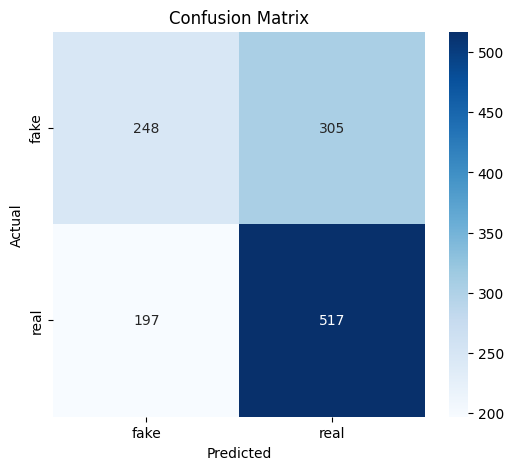


 Top 5 Misclassified Samples:

[0] Statement: building wall usmexico border take literally years
    ➤ True: real | Pred: fake
[2] Statement: says john mccain has done nothing help vets
    ➤ True: fake | Pred: real
[3] Statement: suzanne bonamici supports plan cut choice medicare advantage seniors
    ➤ True: real | Pred: fake
[5] Statement: past years federal government has paid retirement disability benefits deceased former federal employees
    ➤ True: real | Pred: fake
[6] Statement: says tennessee law requires schools receive half proceeds year halfcent increase shelby county sales tax
    ➤ True: real | Pred: fake


,id,label,statement,subject,speaker,job_title,state_info,party_affiliation,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,context,clean_statement,clean_statement_svm,true_label,predicted_label,correct
0,11972.json,1,Building a wall on the U.S.-Mexico border will...,immigration,rick-perry,Governor,Texas,republican,30,30,42,23,18,Radio interview,building wall usmexico border take literally y...,building wall usmexico border take literally y...,1,0,False
1,11685.json,0,Wisconsin is on pace to double the number of l...,jobs,katrina-shankland,State representative,Wisconsin,democrat,2,1,0,0,0,a news conference,wisconsin pace double number layoffs year,wisconsin is pace double number layoffs year,0,0,True
2,11096.json,0,Says John McCain has done nothing to help the ...,"military,veterans,voting-record",donald-trump,President-Elect,New York,republican,63,114,51,37,61,comments on ABC's This Week.,says john mccain done nothing help vets,says john mccain has done nothing help vets,0,1,False
3,5209.json,1,Suzanne Bonamici supports a plan that will cut...,"medicare,message-machine-2012,campaign-adverti...",rob-cornilles,consultant,Oregon,republican,1,1,3,1,1,a radio show,suzanne bonamici supports plan cut choice medi...,suzanne bonamici supports plan cut choice medi...,1,0,False
4,9524.json,0,When asked by a reporter whether hes at the ce...,"campaign-finance,legal-issues,campaign-adverti...",state-democratic-party-wisconsin,unknown,Wisconsin,democrat,5,7,2,2,7,a web video,asked reporter whether hes center criminal sch...,asked reporter hes center criminal scheme viol...,0,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1262,7334.json,1,Says his budget provides the highest state fun...,education,rick-scott,Governor,Florida,republican,28,23,38,34,7,a news conference,says budget provides highest state funding lev...,says budget provides highest state funding lev...,1,1,True
1263,9788.json,0,Ive been here almost every day.,"civil-rights,crime,criminal-justice",jay-nixon,Governor,Missouri,democrat,2,0,0,1,0,"on ABC's ""This Week""",ive almost every day,ive been here almost day,0,1,False
1264,10710.json,0,"In the early 1980s, Sen. Edward Kennedy secret...","bipartisanship,congress,foreign-policy,history",mackubin-thomas-owens,"senior fellow, Foreign Policy Research Institute",Rhode Island,columnist,1,0,0,0,0,a commentary in The Providence Journal,early sen edward kennedy secretly offered help...,early s sen edward kennedy secretly offered he...,0,1,False
1265,3186.json,0,Says an EPA permit languished under Strickland...,"environment,government-efficiency",john-kasich,"Governor of Ohio as of Jan. 10, 2011",Ohio,republican,9,8,10,18,3,a news conference,says epa permit languished strickland new epa ...,says epa permit languished strickland new epa ...,0,0,True


In [15]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

train_df = pd.read_csv('processed_train.csv')
val_df = pd.read_csv('processed_valid.csv')
test_df = pd.read_csv('processed_test.csv')

def remap_labels(df):
    label_map = {
        'false': 0,
        'pants-fire': 0,
        'barely-true': 0,
        'half-true': 1,
        'mostly-true': 1,
        'true': 1
    }
    df['label'] = df['label'].map(label_map)
    return df
train_df = remap_labels(train_df)
val_df = remap_labels(val_df)
test_df = remap_labels(test_df)

# print("训练集标签分布:")
# print(train_df["label"].value_counts())

# print("验证集标签分布:")
# print(val_df["label"].value_counts())

# print("测试集标签分布:")
# print(test_df["label"].value_counts())


def extract_features(train_df, val_df, test_df, max_features=5000):
    vectorizer = TfidfVectorizer(stop_words='english', max_features=max_features)
    X_train = vectorizer.fit_transform(train_df["clean_statement_svm"])
    X_val = vectorizer.transform(val_df["clean_statement_svm"])
    X_test = vectorizer.transform(test_df["clean_statement_svm"])

    y_train = train_df["label"]
    y_val = val_df["label"]
    y_test = test_df["label"]

    return X_train, X_val, X_test, y_train, y_val, y_test, vectorizer

def train_svm_model(X_train, y_train, C=1.0, kernel='linear'):
    svm_model = SVC(C=C, kernel=kernel)
    svm_model.fit(X_train, y_train)
    return svm_model

def predict_and_evaluate(model, X_test, y_test, label_map={0: "fake", 1: "real"}):
    y_pred = model.predict(X_test)
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=["fake", "real"]))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=["fake", "real"], yticklabels=["fake", "real"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    return y_pred

def analyze_predictions(preds, test_df, label_col="label", label_map={0: "fake", 1: "real"}, top_k=5):
    true_labels = test_df[label_col].tolist()
    test_df["true_label"] = test_df[label_col]
    test_df["predicted_label"] = preds
    test_df["correct"] = test_df["true_label"] == test_df["predicted_label"]

    print(f"\n Top {top_k} Misclassified Samples:\n")
    mistakes = test_df[~test_df["correct"]].head(top_k)
    for i, row in mistakes.iterrows():
        print(f"[{i}] Statement: {row['clean_statement_svm']}")
        print(f"    ➤ True: {label_map[row['true_label']]} | Pred: {label_map[row['predicted_label']]}")

    return test_df



X_train, X_val, X_test, y_train, y_val, y_test, vectorizer = extract_features(train_df, val_df, test_df)
svm_model = train_svm_model(X_train, y_train)
preds = predict_and_evaluate(svm_model, X_test, y_test)
analyze_predictions(preds, test_df)

